# Diversity analysis


In [2]:
import os
import pandas as pd
from qiime2 import Visualization
from skbio import OrdinationResults
import matplotlib.pyplot as plt
from seaborn import scatterplot
import numpy as np

import qiime2 as q2

%matplotlib inline
data_dir = 'CE'

Artifacts used for alpha-diversity (start)
- dada2_table_align_filtered.qza  --> taxonomy.ipynb
- fasttree-tree-rooted.qza  --> taxonomy.ipynb
- sepp-tree.qza  --> taxonomy.ipynb

## Alpha rarefaction

Which tree should be chosen to conduct alpha rarefaction? the de-novo tree or fragment insertion tree? 
-> fragment insertion tree was chosen, to get the completest tree possible with as much information as possible.
Artifacts of both trees are visualized here to have a look again:

In [2]:
#denovo
Visualization.load(f'{data_dir}/fasttree-tree-rooted.qzv')

<visualization: Visualization uuid: fa5be120-ab7c-44b2-890e-b75b49207148>

In [3]:
#fragment-insertion
Visualization.load(f'{data_dir}/sepp-tree-placements-tree.qzv')

<visualization: Visualization uuid: c3aa3b89-243a-450b-aa54-475736e5cbb5>

### The following steps were done to analyze alpha diversities.
1. The first thing I did was downloading the metadata again, as it somehow was missing in the directory file CE. If you already have the food-metadata.tsv run normally, if not, remove the hashtags # in the following two cells.
2. Used the `alpha-rarefaction` plugin in order to decide which rarefying threshold is best suited for our data. 
3. Visualized the `diversity alpha-rarefaction` artifact (--p-max-depth 100000) to find out which sequencing depth should be used 
    - **12000** was chosen to not loose to many samples but also not loose too much diversity. Also no big differences were noticed between *de novo* and *fragment insertion tree*. At the end we used the *fragment insertion tree*.
4. Also tested different `diversity alpha-rarefaction` --p-max-depth to double check the chosen rarefaction depth. It was done for --p-max-depth 10000 and 50000.
5. Used `core-metrics-phylogenetic` plugin and inserted 12000 for --p-sampling-depth in order to get many different core-metrics artifacts.
6. Used `diversity alpha-group-significance` plugin to run some statisical tests (Kruskall-Wallis)
7. use `diversity alpha-correlation` to check for correlations (columns - richness of microbial community)
8. some fun with pandas: creating a 2D plot of our data

### 1)

In [8]:
#! wget -nv -O $data_dir/food-metadata.tsv 'https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download'

2022-11-08 16:20:15 URL:https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download [42810/42810] -> "CE/food-metadata.tsv" [1]


In [12]:
#df_meta = pd.read_csv(f'{data_dir}/food-metadata.tsv', sep='\t', index_col=0)

### 2)

for denovo:

In [3]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/fasttree-tree-rooted.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_denovo.qzv

Saved Visualization to: CE/alpha-rarefaction_denovo.qzv


for fragment insertion:

In [12]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion.qzv


### 3)

In [2]:
#denovo tree: number of samples has plateau at around 7000 for rind-type
#could lower --p-max-depth to 10000 \
Visualization.load(f'{data_dir}/alpha-rarefaction_denovo.qzv')

<visualization: Visualization uuid: 56a6d917-f4fa-44a8-9c5b-eb1bf1dd4340>

In [3]:
#fragment insertion tree: number of samples has plateau at around 7000 for rind-type
#could change --p-max-depth  7000\
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion.qzv')

<visualization: Visualization uuid: 451f3775-a4b4-4ef5-85a2-fc702c1dceea>

**Observation:** no major difference was found for denovo vs fragment insertion tree.
I would cut at 12000 and choose that as sequencing depth. The plateau is already reached for almost all fators then and the number of samples starts decreasing. With 12000 we don't loose too many samples. The high rarefaction depth stands for a good sequencing depth quality.


### 4)

--p-max-depth 10000

In [4]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 10000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion_10000.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion_10000.qzv


In [5]:
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion_10000.qzv')

<visualization: Visualization uuid: 18202a81-4f32-4843-b6b1-264745313dad>

--p-max-depth 50000

In [8]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 50000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion_50000.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion_50000.qzv


In [9]:
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion_50000.qzv')

<visualization: Visualization uuid: 05b66370-f55c-4e24-9666-796ee5c4eb2f>

**Observation:** 12'000 seems to be a good rarefaction depth also double checking using these two different max depths.

### 5)

## Diversity analysis

## Alpha diversity

Sequencing depth of 12000 for rarefaction: now let's have a look at the whitin-sample diversity (= alpha div.) Done for fragment-insertion tree.

In [4]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/dada2_table_align_filtered.qza \
  --i-phylogeny $data_dir/sepp-tree.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --p-sampling-depth 12000 \
  --output-dir $data_dir/core-metrics-results_insertion_12000

Saved FeatureTable[Frequency] to: CE/core-metrics-results_insertion_12000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/evenness_vector.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/bray_curtis_distance_matrix.qza
Saved PCoAResults to: CE/core-metrics-results_insertion_12000/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults

### 6)

In [5]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv


In [6]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv')

<visualization: Visualization uuid: b666216f-7507-4a72-91a4-03c56417d2f4>

### 7)

In [7]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv


In [11]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv')

<visualization: Visualization uuid: eb2de2af-9b74-4497-8e1e-9993bfbd15e1>

I feel like this correlation thing isn't necessary....
->> should try ANOVA q2-longitudinal? are assumptions correct tho?

### 8)

#### PANDAS fun

In [15]:
art = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/faith_pd_vector.qza')).view(pd.Series)
md = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['rindtype']

In [16]:
pd.concat([art, md], join = 'inner', axis = 1)

,faith_pd,rindtype
11488.CSB280,9.111393,natural
11488.CSB281,10.492586,natural
11488.CSB282,9.983138,natural
11488.CSB290,4.539658,washed
11488.CSB292,3.130709,washed
...,...,...
11488.CSB980,8.061571,natural
11488.CSB981,6.614198,natural
11488.CSB984,10.555242,natural
11488.CSB985,11.277596,washed


In [17]:
#no change, same rows and columns
artmd = pd.concat([art, md], join = 'inner', axis = 1).dropna()

Text(0.5, 0, 'Rind Type')

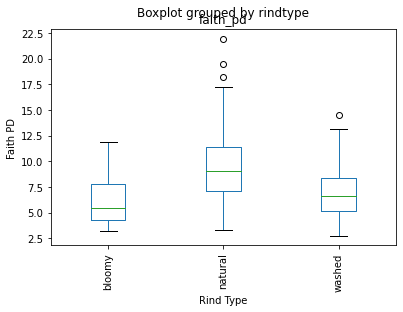

In [18]:
artmd.boxplot(by = 'rindtype', rot=90, grid = False)
plt.ylabel('Faith PD')
plt.xlabel('Rind Type')

---

## Beta diversity

Beta diversity measures the similarity between samples or groups of samples.

Analyse beta diversity from core-metrics-phylogenetic action. Inspect unweighted_unifrac_emperor.qzv:

Some clustering according to rindtype. But no clear clustering.

#### Unweighted UniFrac

In [14]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/unweighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: a2b6d310-3dc4-4b74-b5e1-5dca1757868a>

#### Jaccard

In [3]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/jaccard_emperor.qzv')

<visualization: Visualization uuid: 029aa592-6da7-47a0-b555-69b4699a25a6>

#### Weighted UniFrac

In [4]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/weighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 33c9fd9e-be19-4adc-8bed-d67e0f7ec23c>

#### Bray-Curtis

In [6]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: 52f7557d-ef68-416b-881c-3b3e626391ed>

### PERMANOVA test
Statistical testing of associations between beta diversity and categorical variables.
We perform a PERMANOVA test checking whether the observed categories are significantly grouped in QIIME 2 with the qiime diversity beta-group-significance method.

Inspect the beta diversity metrics of rindtype groupings:

Result: Distances between samples in groups are significantly different from the distance between samples from the other groups as the p-values are all 0.001.

In [19]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column rindtype \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv


In [20]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv')

<visualization: Visualization uuid: 5dd44b9b-0dc0-4f31-8502-6f40fbdf7432>

Inspect the beta diversity metrics of continent groupings:

Result: 

In [21]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column continent \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv


In [22]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv')

<visualization: Visualization uuid: 45cb541f-6e82-478a-80ac-d9fdd1398355>

Inspect the beta diversity metrics of animal source groupings:

In [23]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column animal_source \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv


In [24]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv')

<visualization: Visualization uuid: 4e0b7922-abef-46c0-a0d1-2e4660041a6b>

#### ADONIS

PERMANOVA test can also be performed with the adonis implementation. --> to explain which covariates explain the most variation in our dataset.

Order in formula can make a difference in the outcomes. --> try different orders

In [26]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "rindtype+continent+country+region+animal_source+pasteurized" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis.qzv


In [27]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis.qzv')

<visualization: Visualization uuid: 86634dd3-26e3-4461-9178-3c1a29f9e932>

Order the columns for --p-formula by their R2 from the adonis thest performed before. The highest R2 comes first. This is important as order plays a role in adonis tests.

Result: The region explains the most variation in our dataset (highest R2 value). --> But where is "continent"? :(

In [30]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "region+rindtype+country+animal_source+continent+pasteurized" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis_2.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis_2.qzv


In [31]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis_2.qzv')

<visualization: Visualization uuid: e32a5aa8-78de-4b35-b8a8-b3cf756ccf3d>

In [34]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "region+rindtype+animal_source+pasteurized+country" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis_3.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis_3.qzv


In [35]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis_3.qzv')

<visualization: Visualization uuid: 28d476db-653d-4869-8000-4d6c084888da>

#### PANDAS fun

### 12000

In [5]:
unw_UF_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/unweighted_unifrac_pcoa_results.qza'))
unw_UF_pcoa_res_12000 = unw_UF_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
unw_UF_pcoa_res_data_12000 = unw_UF_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
unw_UF_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

In [6]:
unw_UF_pcoa_res_data_12000.head(3)

,Axis 1,Axis 2,Axis 3
11488.CSB280,0.049976,0.008295,-0.268998
11488.CSB281,0.196987,0.149224,-0.089773
11488.CSB282,0.082988,0.043284,-0.248198


In [7]:
df_meta = pd.read_csv(f'{data_dir}/food-metadata.tsv', sep='\t', index_col=0)

Join this dataframe with metadata column:

In [8]:
unw_UF_pcoa_res_data_with_rindtype_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['rindtype'])
unw_UF_pcoa_res_data_with_rindtype_12000.head()

,Axis 1,Axis 2,Axis 3,rindtype
11488.CSB280,0.049976,0.008295,-0.268998,natural
11488.CSB281,0.196987,0.149224,-0.089773,natural
11488.CSB282,0.082988,0.043284,-0.248198,natural
11488.CSB290,-0.175483,0.165197,-0.013238,washed
11488.CSB292,-0.299215,0.131027,0.022871,washed


Visualize data using Python visualization library seaborn:

<AxesSubplot:xlabel='Axis 1', ylabel='Axis 2'>

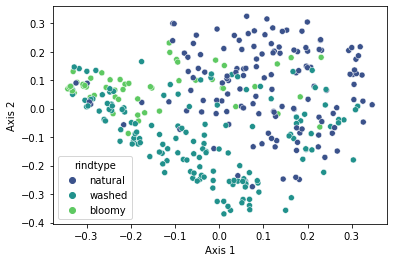

In [9]:
scatterplot(data=unw_UF_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='viridis')

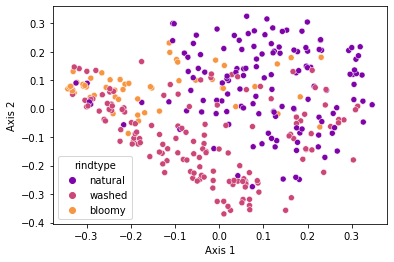

In [20]:
scatterplot(data=unw_UF_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='plasma')
plt.savefig("rindtype_plasma.png", dpi = 400)

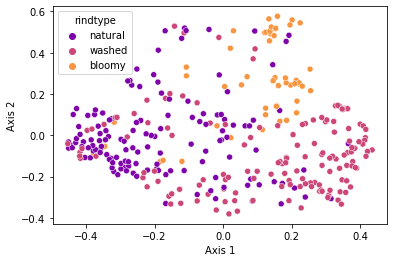

In [31]:
#style weighted unifrac
bray_curtis_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/bray_curtis_pcoa_results.qza'))
bray_curtis_pcoa_res_12000 = bray_curtis_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
bray_curtis_pcoa_res_data_12000 = bray_curtis_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
bray_curtis_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

bray_curtis_pcoa_res_data_with_rindtype_12000 = bray_curtis_pcoa_res_data_12000.join(df_meta['rindtype'])
bray_curtis_pcoa_res_data_with_rindtype_12000.head()
scatterplot(data=bray_curtis_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='plasma')
plt.savefig("rindtype_bray_curtis_plasma.png", dpi = 400)

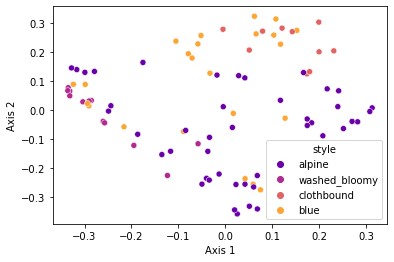

In [19]:
#style unweighted unifrac
unw_UF_pcoa_res_data_with_style_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['style'])
unw_UF_pcoa_res_data_with_style_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_style_12000,
            x='Axis 1',
            y='Axis 2',
            hue='style',
            palette='plasma')
plt.savefig("style_plasma.png", dpi = 400)

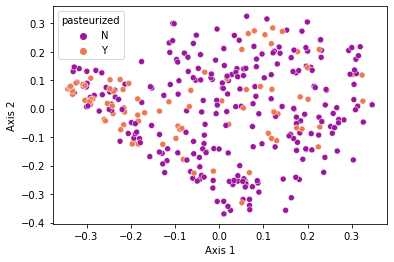

In [21]:
#pasteurized unweighted unifrac
unw_UF_pcoa_res_data_with_pasteurized_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['pasteurized'])
unw_UF_pcoa_res_data_with_pasteurized_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_pasteurized_12000,
            x='Axis 1',
            y='Axis 2',
            hue='pasteurized',
            palette='plasma')
plt.savefig("pasteurized_plasma.png", dpi = 400)

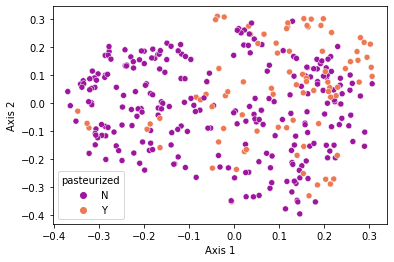

In [30]:
#style weighted unifrac
jaccard_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/jaccard_pcoa_results.qza'))
jaccard_pcoa_res_12000 = jaccard_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
jaccard_pcoa_res_data_12000 = jaccard_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
jaccard_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

jaccard_pcoa_res_data_with_pasteurized_12000 = jaccard_pcoa_res_data_12000.join(df_meta['pasteurized'])
jaccard_pcoa_res_data_with_pasteurized_12000.head()
scatterplot(data=jaccard_pcoa_res_data_with_pasteurized_12000,
            x='Axis 1',
            y='Axis 2',
            hue='pasteurized',
            palette='plasma')
plt.savefig("pasteurized_jaccard_plasma.png", dpi = 400)

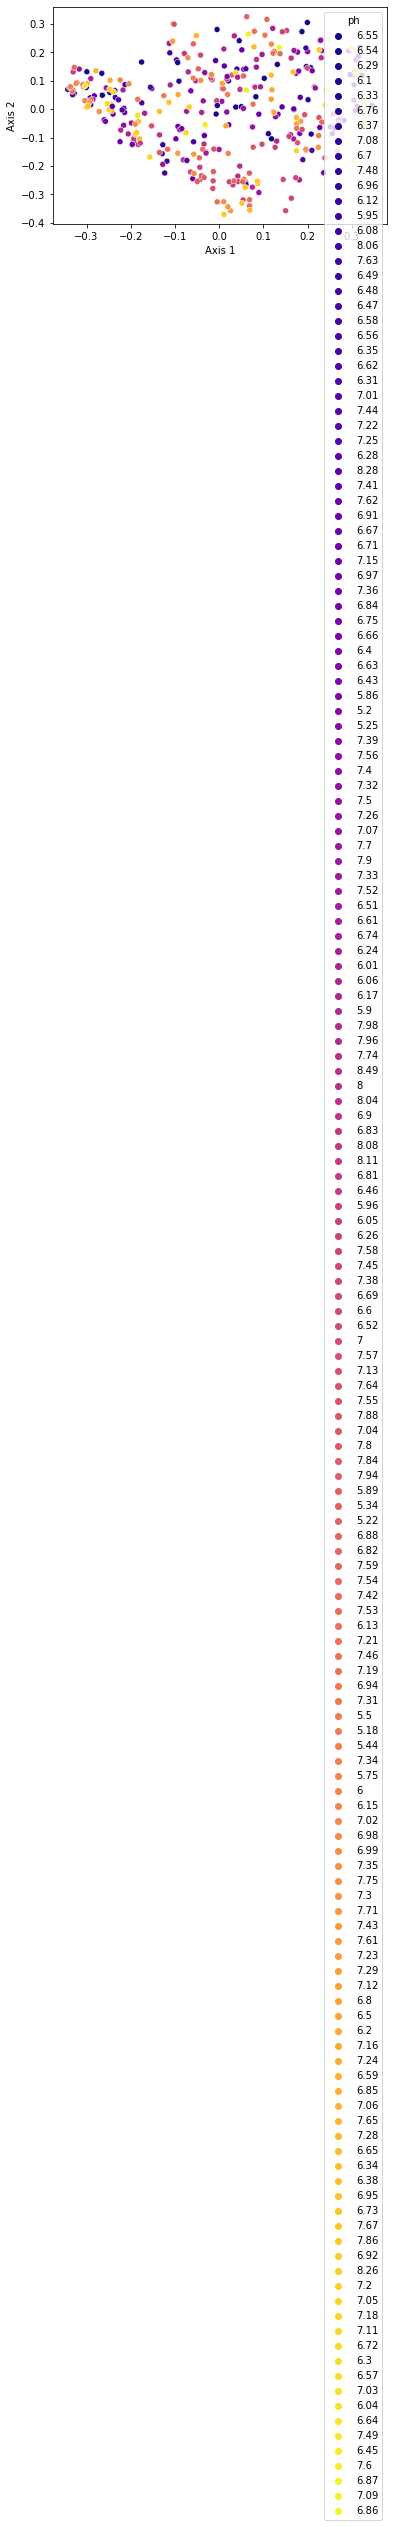

In [23]:
#pH
unw_UF_pcoa_res_data_with_ph_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['ph'])
unw_UF_pcoa_res_data_with_ph_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_ph_12000,
            x='Axis 1',
            y='Axis 2',
            hue='ph',
            palette='plasma')
plt.savefig("ph_plasma.png", dpi = 400)
#visible, that there is no gradient

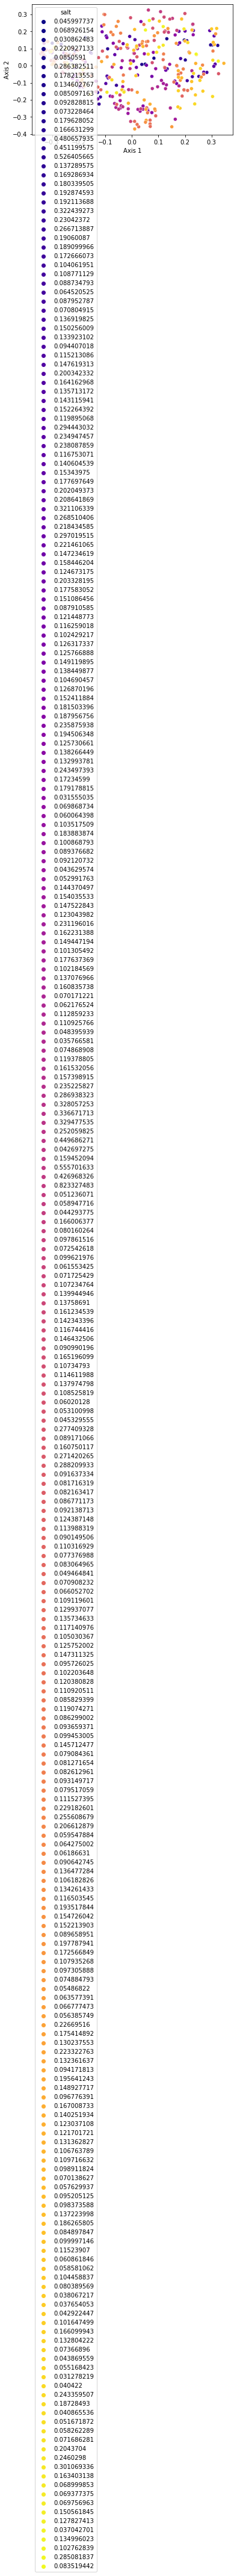

In [24]:
#salt
unw_UF_pcoa_res_data_with_salt_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['salt'])
unw_UF_pcoa_res_data_with_salt_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_salt_12000,
            x='Axis 1',
            y='Axis 2',
            hue='salt',
            palette='plasma')
plt.savefig("salt_plasma.png", dpi = 400)
#visible, that there is no gradient